# Q6)

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn import preprocessing

bodyfat = pd.read_csv("./bodyfat.csv")

X = bodyfat.drop(columns=["BodyFat","Density"])
y = bodyfat["BodyFat"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state = 10
)

kf = KFold(n_splits = 5, shuffle = True, random_state = 10)
cv_fold = np.zeros(len(y_train)).astype(int)
for i, (_, fold_indexes) in enumerate(kf.split(X_train)):
    cv_fold[fold_indexes] = int(i)

## B)

In [2]:
from itertools import combinations

def get_all_possible_subsets(n, features):
    return list(combinations(features, n))

## Best subset selection
overall_best_params_bs = None
overall_max_coef_bs = 0
best_model_by_numb_pred_bs = {}
for numb_pred in range(1, 14):

    # Get all possible subsets and remove duplicates
    possibilities = get_all_possible_subsets(numb_pred, X_train.columns)
    possibilities = [tuple(sorted(possibility)) for possibility in possibilities]
    possibilities = list(set(possibilities))

    possibilit_max_coef = 0
    for possibilit in possibilities:
        r2_coef = 0
        # We perform a 5-fold cross validation
        for fold_index in range(0, 5):
            x_fold_train = X_train.loc[cv_fold != fold_index, possibilit]
            y_fold_train = y_train.loc[cv_fold != fold_index]
            fitted_lm = sm.OLS(y_fold_train, x_fold_train).fit()

            y_fold_validation = y_train.loc[cv_fold == fold_index]
            x_fold_validation = X_train.loc[cv_fold == fold_index, possibilit]

            y_fold_validation_pred = fitted_lm.predict(x_fold_validation)

            # R2 coefficient on the validation set
            r2_coef += 1 - np.sum((y_fold_validation - y_fold_validation_pred) ** 2) / np.sum((y_fold_validation - np.mean(y_fold_validation)) ** 2)

        # avg of the r2 coefficient on the 5 folds for this subset of features
        avg_r2_coef = r2_coef / 5 

        # If the model with this subset of features is better than the previous best model, we save its features and update the best r2 coefficient 
        if possibilit_max_coef < avg_r2_coef:
            possibilit_max_coef = avg_r2_coef
            best_subset = [param for param in possibilit]

    best_model_by_numb_pred_bs[numb_pred] = {
        "features": best_subset, 
        "r2coef": possibilit_max_coef
    }

    # If the model with this number of features is better than the previous best model, we save its features and update the best r2 coefficient
    if overall_max_coef_bs < possibilit_max_coef:
        overall_max_coef_bs = possibilit_max_coef
        overall_best_params_bs = best_subset

# Retrain the best model using all training data
best_bs_model = sm.OLS(y_train, X_train[overall_best_params_bs]).fit()

In [3]:
# Forward stepwise selection
overall_best_params_forward = None
overall_max_coef_forward = 0
best_model_by_numb_pred_forward = {}
previous_stage_best_features = []

for numb_pred_forward in range(1, 14):
    available_features = set(X_train.columns) - set(previous_stage_best_features)
    possibilit_max_coef = 0
    for feature in available_features:
        # We add a new feature to the previous best subset of features to test the model with this new subset
        new_features = previous_stage_best_features + [feature]
        r2_coef = 0
        # We perform a 5-fold cross validation
        for fold_index in range(0, 5):
            x_fold_train = X_train.loc[cv_fold != fold_index, new_features]
            y_fold_train = y_train.loc[cv_fold != fold_index]
            fitted_lm = sm.OLS(y_fold_train, x_fold_train).fit()

            y_fold_validation = y_train.loc[cv_fold == fold_index]
            x_fold_validation = X_train.loc[cv_fold == fold_index, new_features]

            y_fold_validation_pred = fitted_lm.predict(x_fold_validation)

            r2_coef += 1 - np.sum((y_fold_validation - y_fold_validation_pred) ** 2) / np.sum((y_fold_validation - np.mean(y_fold_validation)) ** 2)
        avg_r2_coef = r2_coef / 5

        # If the model with this subset of features is better than the previous best model, we save its features and update the best r2 coefficient
        if possibilit_max_coef < avg_r2_coef:
            possibilit_max_coef = avg_r2_coef
            best_subset = new_features
    
    # Save the best model for this number of features
    best_model_by_numb_pred_forward[numb_pred_forward] = {
        "features": best_subset, 
        "r2coef": possibilit_max_coef
    }
    previous_stage_best_features = best_subset

    # Save the best overall model
    if overall_max_coef_forward < possibilit_max_coef:
        overall_max_coef_forward = possibilit_max_coef
        overall_best_params_forward = best_subset

# Retrain the best model using all training data
best_forward_model = sm.OLS(y_train, X_train[overall_best_params_forward]).fit()

In [4]:
# Backward stepwise selection
overall_best_params_backward = None
overall_max_coef_backward = 0
best_model_by_numb_pred_backward = {}
previous_stage_best_features = list(X_train.columns)


# Include the case where no variable is removed
r2_coef = 0
for fold_index in range(0, 5):
    x_fold_train = X_train.loc[cv_fold != fold_index]
    y_fold_train = y_train.loc[cv_fold != fold_index]
    fitted_lm = sm.OLS(y_fold_train, x_fold_train).fit()

    y_fold_validation = y_train.loc[cv_fold == fold_index]
    x_fold_validation = X_train.loc[cv_fold == fold_index]

    y_fold_validation_pred = fitted_lm.predict(x_fold_validation)

    r2_coef += 1 - np.sum((y_fold_validation - y_fold_validation_pred) ** 2) / np.sum((y_fold_validation - np.mean(y_fold_validation)) ** 2)

best_model_by_numb_pred_backward[13] = {
    "features": list(X_train.columns),
    "r2coef": r2_coef / 5
}

for numb_removed_pred_backward in range(1, 13):

    available_features = set(previous_stage_best_features)

    possibilit_max_coef = 0
    for feature in available_features:
        # We remove a feature from the previous best subset of features to test the model with this new subset
        new_features = list(set(previous_stage_best_features) - set([feature]))
        r2_coef = 0
        # We perform a 5-fold cross validation
        for fold_index in range(0, 5):
            x_fold_train = X_train.loc[cv_fold != fold_index, new_features]
            y_fold_train = y_train.loc[cv_fold != fold_index]
            fitted_lm = sm.OLS(y_fold_train, x_fold_train).fit()

            y_fold_validation = y_train.loc[cv_fold == fold_index]
            x_fold_validation = X_train.loc[cv_fold == fold_index, new_features]

            y_fold_validation_pred = fitted_lm.predict(x_fold_validation)

            r2_coef += 1 - np.sum((y_fold_validation - y_fold_validation_pred) ** 2) / np.sum((y_fold_validation - np.mean(y_fold_validation)) ** 2)
        avg_r2_coef = r2_coef / 5

        # If the model with this subset of features is better than the previous best model, we save its features and update the best r2 coefficient
        if possibilit_max_coef < avg_r2_coef:
            possibilit_max_coef = avg_r2_coef
            best_subset = new_features

    # Save the best model for this number of features
    best_model_by_numb_pred_backward[13 - numb_removed_pred_backward] = {
        "features": best_subset, 
        "r2coef": possibilit_max_coef
    }
    previous_stage_best_features = best_subset

    # Save the best overall model
    if overall_max_coef_backward < possibilit_max_coef:
        overall_max_coef_backward = possibilit_max_coef
        overall_best_params_backward = best_subset

# Retrain the best model using all training data
best_backward_model = sm.OLS(y_train, X_train[overall_best_params_backward]).fit()

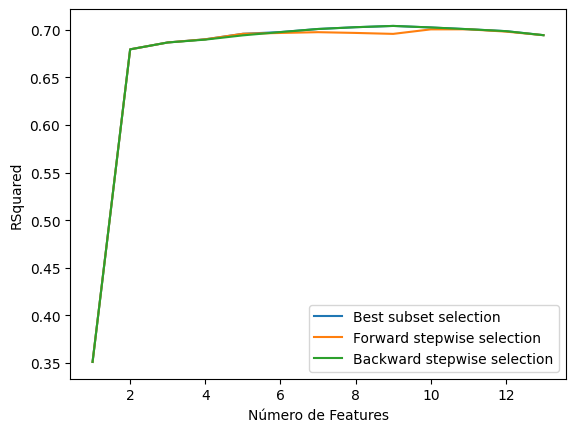

In [ ]:
plt.plot(
    list(best_model_by_numb_pred_bs.keys()), 
    [best_model_by_numb_pred_bs[key]["r2coef"] for key in best_model_by_numb_pred_bs.keys()],
    label="Best subset selection"
)

plt.plot(
    list(best_model_by_numb_pred_forward.keys()), 
    [best_model_by_numb_pred_forward[key]["r2coef"] for key in best_model_by_numb_pred_forward.keys()],
    label="Forward stepwise selection"
)

plt.plot(
    list(best_model_by_numb_pred_backward.keys()), 
    [best_model_by_numb_pred_backward[key]["r2coef"] for key in best_model_by_numb_pred_backward.keys()],
    label="Backward stepwise selection"
)

plt.xlabel('Number of Features')
plt.ylabel('RSquared')
plt.legend()
plt.show()

## D)

In [16]:
alphas = 10**np.linspace(5,-2,100)

In [17]:
X_train_processed = preprocessing.scale(X_train)

min_mse = np.inf
best_alpha = None
alpha_and_mse = {}
# Lasso for all alphas
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    sum_mse = 0
    for fold_index in range(0, 5):
        x_fold_train = X_train_processed[cv_fold != fold_index]
        y_fold_train = y_train[cv_fold != fold_index]
        lasso_model.fit(x_fold_train, y_fold_train)

        y_fold_validation = y_train[cv_fold == fold_index]
        x_fold_validation = X_train_processed[cv_fold == fold_index]
        y_fold_validation_pred = lasso_model.predict(x_fold_validation)

        sum_mse += np.sum((y_fold_validation - y_fold_validation_pred) ** 2) / len(y_fold_validation)

    avg_mse = sum_mse / 5
    alpha_and_mse[alpha] = avg_mse

    if avg_mse < min_mse:
        min_mse = avg_mse
        best_alpha = alpha

# Retrain the best model using all training data
lasso_model = Lasso(alpha=best_alpha)
best_lasso_model = lasso_model.fit(X_train_processed, y_train)

Text(0.5, 0, 'Alpha')

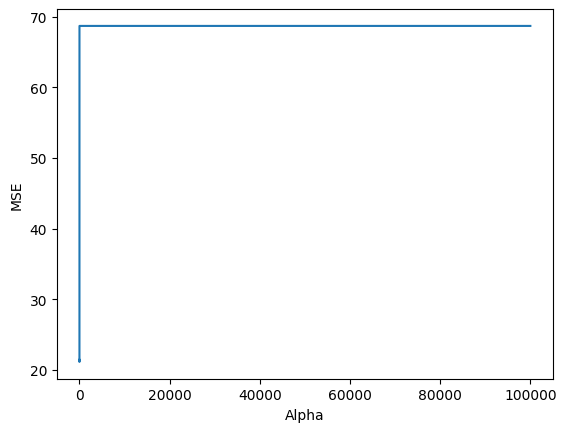

In [18]:
plt.plot(
    list(alpha_and_mse.keys()), 
    [alpha_and_mse[key] for key in alpha_and_mse.keys()],
)

plt.ylabel('MSE')
plt.xlabel('Alpha')

## E) Vamos supor que k deve ser tq o modelo apresente menor Rsquared

In [19]:
# MSE for lasso
X_test_processed = preprocessing.scale(X_test)
y_test_pred_lasso = best_lasso_model.predict(X_test_processed)
mse_test_lasso = np.sum((y_test - y_test_pred_lasso) ** 2) / len(y_test)

# MSE for best subset selection
X_test_best_bs = X_test[overall_best_params_bs]
y_test_pred_bs = best_bs_model.predict(X_test_best_bs)
mse_test_bs = np.sum((y_test - y_test_pred_bs) ** 2) / len(y_test)

# MSE for forward stepwise selection
X_test_best_forward = X_test[overall_best_params_forward]
y_test_pred_forward = best_forward_model.predict(X_test_best_forward)
mse_test_forward = np.sum((y_test - y_test_pred_forward) ** 2) / len(y_test)

# MSE for backward stepwise selection
X_test_best_backward = X_test[overall_best_params_backward]
y_test_pred_backward = best_backward_model.predict(X_test_best_backward)
mse_test_backward = np.sum((y_test - y_test_pred_backward) ** 2) / len(y_test)

print(
    f"MSE - Lasso: {mse_test_lasso}",
    f"MSE - Best subset selection: {mse_test_bs}",
    f"MSE - Forward stepwise selection: {mse_test_forward}",
    f"MSE - Backward stepwise selection: {mse_test_backward}"
)

MSE - Lasso: 16.062248033733823 MSE - Best subset selection: 16.366309346853466 MSE - Forward stepwise selection: 16.704696595152456 MSE - Backward stepwise selection: 16.366309346853328
